In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics

In [2]:
data_raw = pd.read_csv('data/train.csv')

# Problema: Satisfação do cliente

## Classificações:
    - Positivo = Insatisfeito
    - Negativo = Satisfeito


## "Custo" das previsões:
    - Falso Positivo: R$ -10,00
- Falso Negativo: R$ 0,00
    - Verdadeiro Positivo: R$ 90,00
- Verdadeiro Negativo: R$ 0,00

# Proposta:
### a) Maximizar o lucro, considerando o contexto acima
### b) Classificar cada cliente com nota de 1-5 (1= mais insatisfeito, 5= mais satisfeito) e considerar que clientes com nota 1 são alvos de ação
### c) Identificar clusters naturais e encontras os 3 grupos que trazem os maiores lucros

In [3]:
data_raw.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
data_raw.groupby('TARGET').count()[['ID']]

,ID
TARGET,
0,73012
1,3008


In [5]:
data = data_raw.drop('ID', axis=1)

### (funções auxiliares)

In [6]:
def predict(fitted, X, threshold=0.5):
    return fitted.predict_proba(X)[:, 0] < threshold

def calc_profit(fitted, X, y, threshold=0.5, printstats=False):
    y_pred = predict(fitted, X, threshold)
    tp = (y_pred==1) & (y==1)
    tp_score = sum(tp * 100)
    pred_score = sum(y_pred)*-10
    score = (tp_score + pred_score)/len(y)
    if printstats:
        print('threshold', threshold, '\ttp_score', tp_score, '\tpred_score', pred_score, '\ttotal score', score)
    return score

# Feature Selection

### Análise de correlação

In [7]:
corr = data.corr()

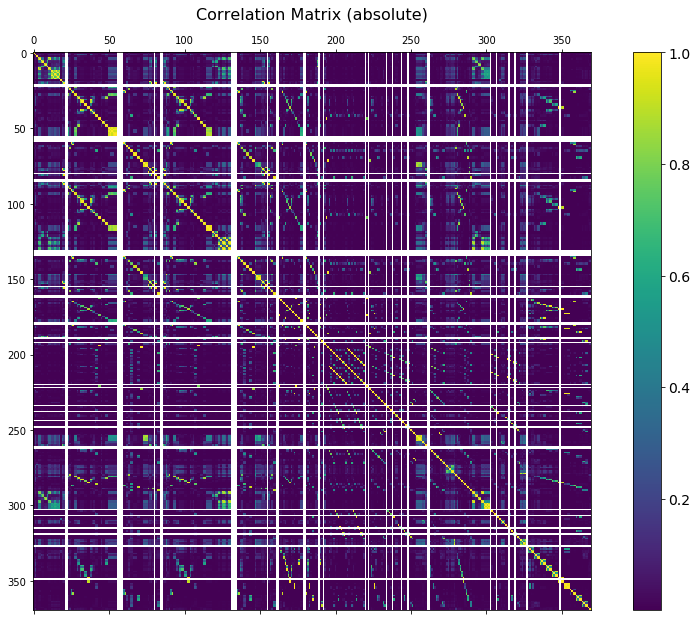

In [8]:
f = plt.figure(figsize=(15, 10))
plt.matshow(corr.abs(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix (absolute)', fontsize=16);

In [9]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
data = data.drop(to_drop, axis=1)

### Feature importance segundo um modelo de Random Forrest

In [10]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
rf = RandomForestClassifier()

In [12]:
rf_fitted = rf.fit(X_train, y_train)

/usr/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [13]:
rf_importances = pd.Series(rf_fitted.feature_importances_, index=X.columns).sort_values(ascending=False)

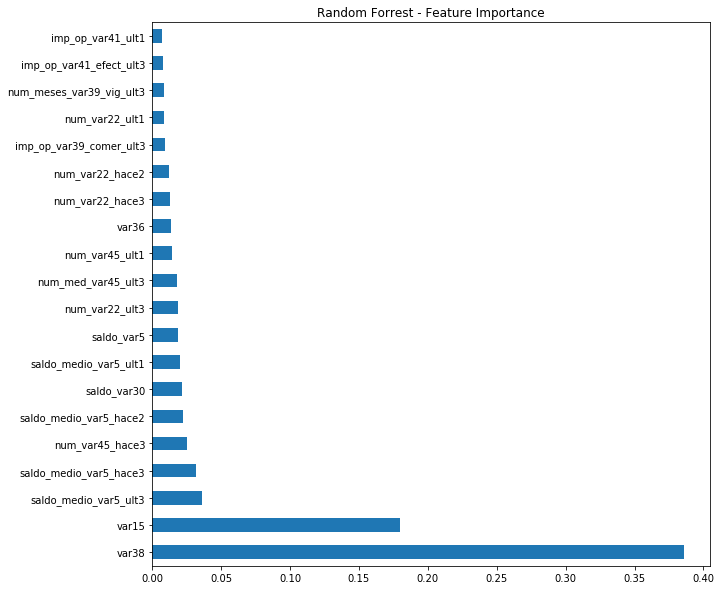

In [14]:
fig = plt.figure(figsize=(10, 10))
rf_importances[0:20].plot(kind='barh', title='Random Forrest - Feature Importance')
plt.show()

In [15]:
X_train_reduced = X_train[rf_importances[0:60].index]
X_test_reduced = X_test[rf_importances[0:60].index]

# a) Maximização do Lucro

## Random Forrest

In [16]:
rf_fitted = RandomForestClassifier().fit(X_train, y_train)
rf_fitted_r = RandomForestClassifier().fit(X_train_reduced, y_train)

/usr/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [17]:
y_pred = rf_fitted.predict(X_test)

print('accuracy', metrics.accuracy_score(y_test, y_pred))
print('precision', metrics.precision_score(y_test, y_pred))
print('recall', metrics.recall_score(y_test, y_pred))

accuracy 0.9533806892922915
precision 0.14772727272727273
recall 0.03412073490813648


In [18]:
y_pred = rf_fitted_r.predict(X_test_reduced)

print('accuracy', metrics.accuracy_score(y_test, y_pred))
print('precision', metrics.precision_score(y_test, y_pred))
print('recall', metrics.recall_score(y_test, y_pred))

accuracy 0.9530123651670613
precision 0.15706806282722513
recall 0.03937007874015748


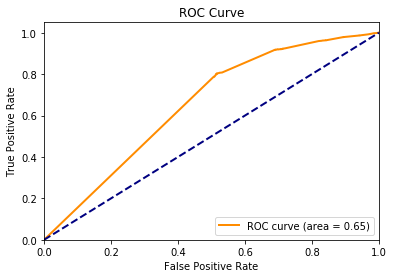

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_fitted.predict_proba(X_test)[:, 0])

plt.figure()
lw = 2
plt.plot(tpr, fpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(tpr, fpr))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Gradient Boosting

In [20]:
gb_fitted = GradientBoostingClassifier().fit(X_train, y_train)
gb_fitted_r = GradientBoostingClassifier().fit(X_train_reduced, y_train)

In [21]:
y_pred = gb_fitted.predict(X_test)

print('accuracy', metrics.accuracy_score(y_test, y_pred))
print('precision', metrics.precision_score(y_test, y_pred))
print('recall', metrics.recall_score(y_test, y_pred))

accuracy 0.9598000526177322
precision 0.375
recall 0.003937007874015748


In [22]:
y_pred = gb_fitted_r.predict(X_test_reduced)

print('accuracy', metrics.accuracy_score(y_test, y_pred))
print('precision', metrics.precision_score(y_test, y_pred))
print('recall', metrics.recall_score(y_test, y_pred))

accuracy 0.959431728492502
precision 0.23529411764705882
recall 0.005249343832020997


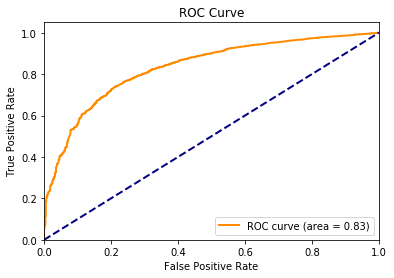

In [23]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, gb_fitted.predict_proba(X_test)[:, 0])

plt.figure()
lw = 2
plt.plot(tpr, fpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(tpr, fpr))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [31]:
lucro_rf = calc_profit(rf_fitted, X_test, y_test)
lucro_gb = calc_profit(gb_fitted, X_test, y_test)

print('Lucro Random Forrest:', lucro_rf, '\nLucro Gradient Boosting:', lucro_gb)

Lucro Random Forrest: 0.04419889502762431 
Lucro Gradient Boosting: 0.01157590107866351


## Formulação

Segundo a problematização do case, o lucro pode ser dado por:
$$
lucro = 100 \times TP-10 \times (TP+FP)
$$
$$
TP = True Positive
$$
$$
FP = False Positive
$$

Assim, pode-se observar que o lucro é representado pelas mesmas variáveis que compõem o cálculo de Precisão.
$$
precision = \frac{TP}{TP+FP}
$$

Portanto, o lucro terá relação direta com a precisão do modelo, sendo:
$$
\frac{lucro}{TP+FP} = 100 \times precision - 10
$$

$$
lucro = (100 \times precision - 10) \times (TP+FP)
$$

Mesmo apresentando menor lucro por cliente, o modelo de Gradient Boosting foi selecionado, pois obteve melhores resultados de AUC e, principalmente, precisão.

O modelo pode ser aperfeiçoado se variando o valor do threshold.

# b) Rating de satisfação (1-5)

# Tweaking the threshold

In [61]:
sc = 100
#thresholds = [x/sc for x in range(int(0*sc), int(1*sc)+1)]
_, _, thresholds = metrics.roc_curve(y_test, rf_fitted.predict_proba(X_test)[:, 0])
scores = np.array([(t, calc_profit(rf_fitted, X_test, y_test, t, False)) for t in thresholds])

(0.8, 1)

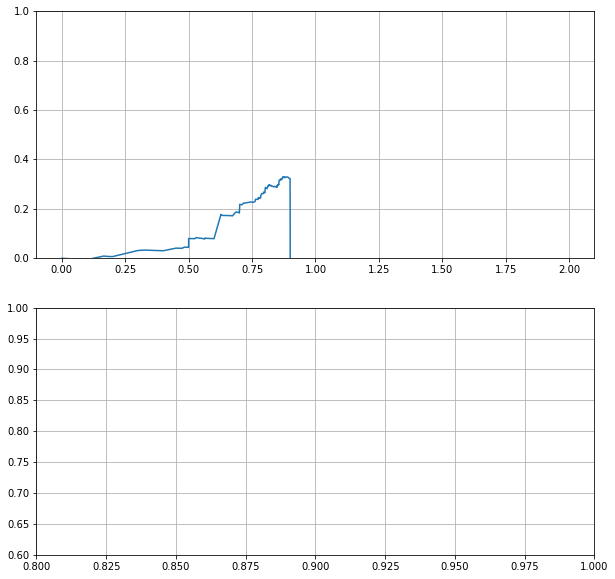

In [62]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(scores[:,0], scores[:,1])
ax[0].grid()
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 1)

ax[1].plot(scores[:,0], scores[:,1])
ax[1].grid()
ax[1].set_ylim(0.6, 1)
ax[1].set_xlim(0.8, 1)

In [63]:
sc = 100
#thresholds = [x/sc for x in range(int(0*sc), int(1*sc)+1)]
_, _, thresholds = metrics.roc_curve(y_test, gb_fitted.predict_proba(X_test)[:, 0])
scores = np.array([(t, calc_profit(gb_fitted, X_test, y_test, t, False)) for t in thresholds])

(0.8, 1)

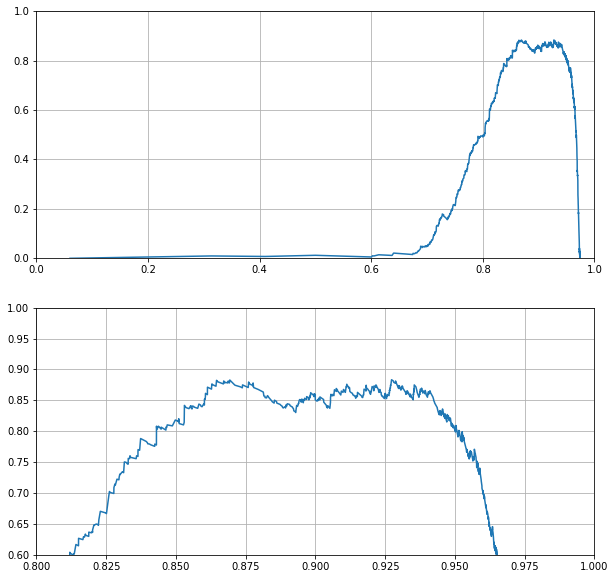

In [74]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(scores[:,0], scores[:,1])
ax[0].grid()
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 1)

ax[1].plot(scores[:,0], scores[:,1])
ax[1].grid()
ax[1].set_ylim(0.6, 1)
ax[1].set_xlim(0.8, 1)

In [38]:
test_data = pd.read_csv('data/test.csv').drop(['ID'] + to_drop, axis=1)

In [73]:
scores

array([[ 1.99748229, -5.99052881],
       [ 0.99748229, -5.99000263],
       [ 0.99651022, -5.98789792],
       ...,
       [ 0.40985991,  0.00736648],
       [ 0.31358777,  0.00947119],
       [ 0.06009466,  0.        ]])

In [86]:
idx = np.where(scores[:,1]==scores[:,1].max())
t, s = scores[idx][0]
print('threshold:', t, '\tscore:', s)

threshold: 0.927274987386992 	score: 0.8834517232307287


In [82]:
sum(predict(gb_fitted, test_data, t))*100

1023600

In [87]:
s*len(test_data)

66981.54275190739

In [92]:
sum(predict(gb_fitted, X_test, t)==y_test)/len(y_test)

0.8685082872928177

# Clustering